In [22]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf

import numpy as np
np.set_printoptions(suppress=True)


In [23]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/rgb/"
config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_50000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=5, eval_every=500, validate_eve

In [24]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [159]:
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/data1/episode_15.hdf5"
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/data2/episode_7.hdf5"

index = 50

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        qpos_np = root["/observations/qpos"][index]
        img_np = root["/observations/images/wrist"][index]
        print("img_np: ",img_np.shape)

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_img = pre_proccess_img(img_np)
        # print("qpos: ",qpos.shape)
        print("curr_img: ",curr_img.shape)
        all_actions = policy(qpos, curr_img)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)



img_np:  (480, 640, 3)
curr_img:  torch.Size([1, 1, 3, 480, 640])
all_actions:  (100, 5)
action_obs_np:  (265, 5)


In [160]:
print(qpos_np)

[-0.1462421  -0.4752514  -0.97891504  1.3784662 ]


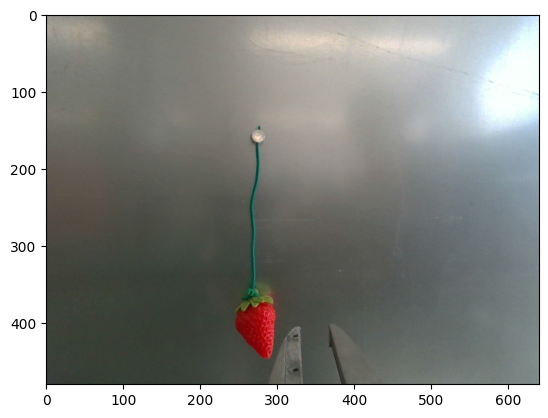

In [161]:
plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

In [162]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)
# print(actual_actions)

In [163]:
actual_action[:4]

array([-0.13624062, -0.43245748, -0.43256873,  0.65660185], dtype=float32)

In [164]:
actual_action[4]

0.0018945625

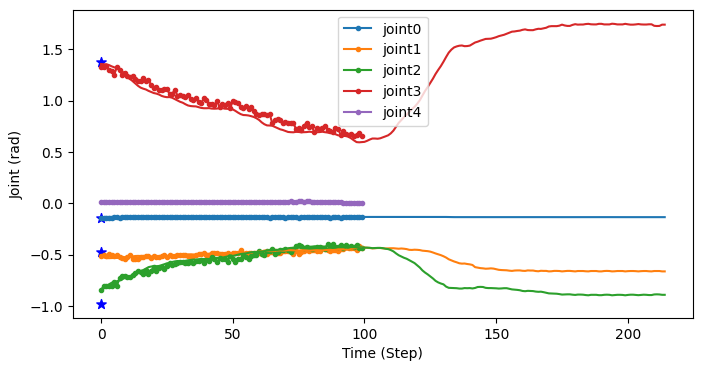

In [165]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')
steps_plot = np.arange(0, len(action_obs_np[index:]), 1)
plt.plot(steps_plot, action_obs_np[index:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[index:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[index:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[index:, 3],  c="C%i"%(3 ), label='joint3')

In [166]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
from utils import robot_visualize as rbvis
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("./hitbot_model.urdf")
print("ok: ", ok)
tree


ok:  True


world(q_nr: 0)
 	body_link(q_nr: 0)
 	base_link(q_nr: 0)
 	link1(q_nr: 0)
 	link2(q_nr: 1)
 	link3(q_nr: 2)
 	link4(q_nr: 3)
 	camera_link(q_nr: 0)
 	
	ee_link(q_nr: 0)
 	
	
	
	
	
	
	
	

In [168]:
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


In [169]:

def plot_robot_2d_xy_batch(link_poses_list):
    """
    Plot the robot in 2d x-y space using matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i, link_poses in enumerate(link_poses_list):
        # Loop over all poses
        prev_x, prev_y, prev_z = None, None, None
        for name, pose in link_poses:
            # Extract the x, y, and z coordinates from the pose
            x, y, z = pose.p[0], pose.p[1], pose.p[2]
            
            # Plot the point on the axes
            ax.scatter(x, y, c='r')
            
            # If it's not the first point, draw a line from the previous point to the current point
            if prev_x is not None:
                ax.plot([prev_x, x], [prev_y, y], c='r')
            prev_x, prev_y, prev_z = x, y, z
    ax.set_ylim([-0.5, 0.1])
    ax.set_xlim([-0.01, 0.6])

    # axis label
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')



In [170]:
len(action_obs_np)

265

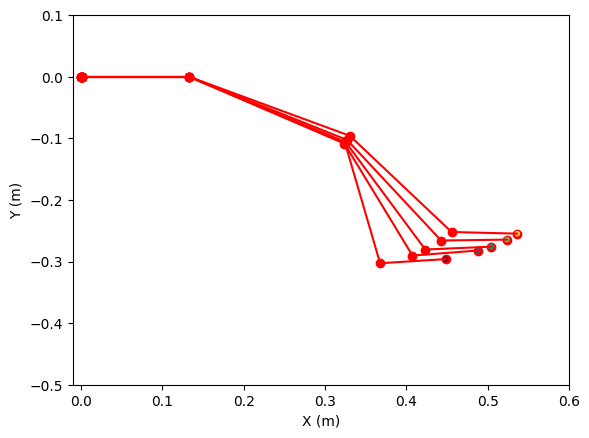

In [171]:
start_action_idx = 0
action_len = 100
link_poses_list = []
ee_poses = []
for i in range(start_action_idx, start_action_idx+action_len, 20):
    # action = action_obs_np[i]
    action = actual_actions[i]

    joint_states = rbvis.joint_states_to_jnt_array(action[:4])
    link_poses = rbvis.get_poses(fk_solver, chain, joint_states)
    link_poses_list.append(link_poses)
    ee_poses.append([link_poses[-1][1].p[0], link_poses[-1][1].p[1], link_poses[-1][1].p[2]])
plot_robot_2d_xy_batch(link_poses_list)
ee_poses = np.asarray(ee_poses)
plt.scatter(ee_poses[:, 0], ee_poses[:, 1], c=range(len(ee_poses)), marker='.')

# Display the plot
plt.show()

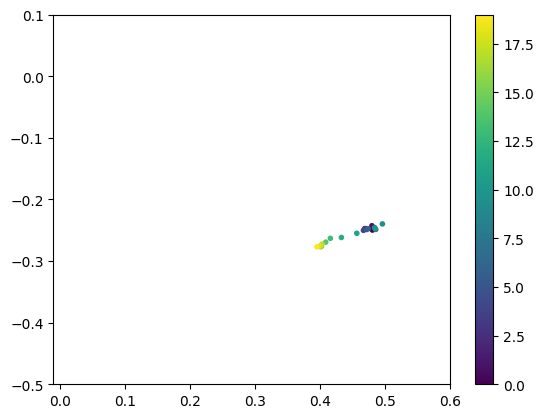

In [150]:
plt.scatter(ee_poses[:, 0], ee_poses[:, 1], c=range(len(ee_poses)), marker='.')
plt.ylim([-0.5, 0.1])
plt.xlim([-0.01, 0.6])
plt.colorbar()

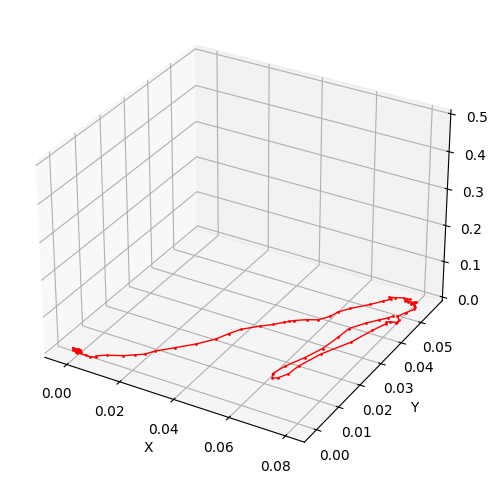

In [166]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')



ax.plot(ee_poses[:, 0], ee_poses[:, 1], ee_poses[:,2 ]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 0.5)
ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

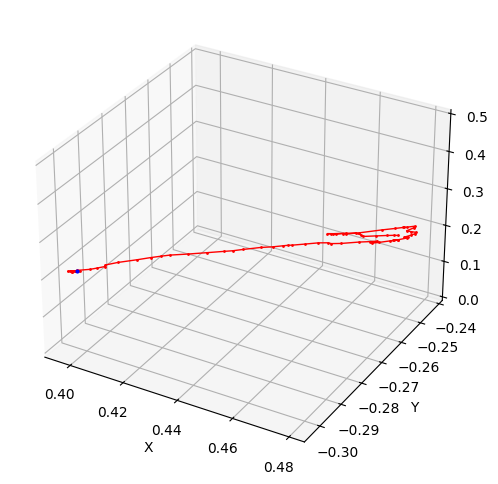

In [167]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')



ax.plot(*zip(*gt_ee_pose[:80]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)
ax.plot(*zip(init_pose), color='blue', marker='o', linestyle='-', linewidth=1, markersize=2)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
ax.set_zlim(0, 0.5)
ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [134]:
util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj


In [135]:
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 0.0, 0.0, 429.129150390625, 242.32749938964844, 0.0, 0.0, 0.0, 1.0, 0.0]
]).reshape([3, 4])
rgb_p

array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [136]:
# simulate a line to front
pts_ee = []
for i in range(10):
    pts_ee.append([0.1 * i, 0, 0])
pts_ee = np.asarray(pts_ee)
pts_ee

array([[0. , 0. , 0. ],
       [0.1, 0. , 0. ],
       [0.2, 0. , 0. ],
       [0.3, 0. , 0. ],
       [0.4, 0. , 0. ],
       [0.5, 0. , 0. ],
       [0.6, 0. , 0. ],
       [0.7, 0. , 0. ],
       [0.8, 0. , 0. ],
       [0.9, 0. , 0. ]])

In [137]:
pts_ee = ee_in_init_poss.copy()
pts_ee[0]

array([-0., -0.,  0.])

In [172]:
# camera_T_lidar = np.diag([1, 1, 1, 1])
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0, 0])
# camera_T_ee = trans.states2SE3([0.12, -0.008, -0.05, 0, 0.2, -0.20])
# camera_T_ee = trans.states2SE3([0.1, 0, 0, 0, 0, 0])

pts_camera = camera_T_ee.dot(trans.xyz2homo(pts_ee).T).T[:,: 3]
# pts_camera

In [173]:
pts_in_camera_opt = pts_camera.copy()
pts_in_camera_opt = pts_in_camera_opt[:, [1, 2, 0]]
pts_in_camera_opt[:, 2] = pts_in_camera_opt[:, 2]
pts_in_camera_opt[:, 0] = -pts_in_camera_opt[:, 0]
pts_in_camera_opt[:, 1] = -pts_in_camera_opt[:, 1]


In [174]:
# uv = project_points_to_uv_batch(rgb_p, pts_optical)
uvs = proj.project_point_to_image(pts_in_camera_opt, rgb_p)


img_np:  (480, 640, 3)


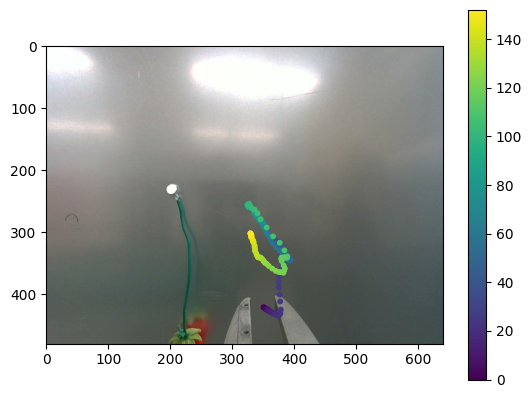

In [175]:
with h5py.File(h5data_file, "r") as root:
    img_np = root["/observations/images/wrist"][0]
print("img_np: ",img_np.shape)
img_plot = img_np.copy()

plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
plt.colorbar()